# Vorhersage eines Triebwerksausfalls aufgrund von Sensormesswerten

In [1]:
import h5py
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = '../data/N-CMAPSS_DS03-012.h5'

In [3]:
# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # Sensors
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # Sensors
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))

In [16]:
df_A = DataFrame(data=A_dev, columns=A_var)
df_A_test = DataFrame(data=A_test, columns=A_var)
df_A.describe()


,unit,cycle,Fc,hs
count,5.571277e+06,5.571277e+06,5.571277e+06,5.571277e+06
mean,5.382994e+00,3.637726e+01,2.170105e+00,3.319295e-01
std,2.399958e+00,2.157529e+01,7.257075e-01,4.709059e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,1.800000e+01,2.000000e+00,0.000000e+00
50%,6.000000e+00,3.600000e+01,2.000000e+00,0.000000e+00
75%,8.000000e+00,5.400000e+01,3.000000e+00,1.000000e+00
max,9.000000e+00,9.300000e+01,3.000000e+00,1.000000e+00


### Unit Ids 
Mit diesem Codeabschnitt wird geschaut wie viele Triebwerke im Devset und im Testset sind.

In [17]:
print(np.unique(df_A["unit"]))
print(np.unique(df_A_test["unit"]))

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[10. 11. 12. 13. 14. 15.]


### Verfügbare Triebwerke pro Flugklasse

Text(0, 0.5, 'Flight Class # [-]')

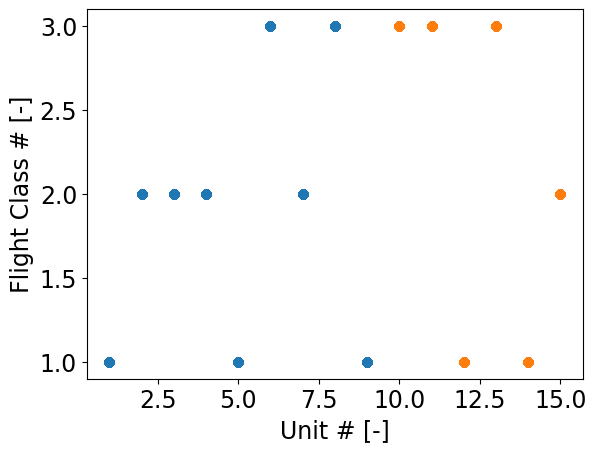

In [61]:
labelsize = 17
# devset 
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

# testset
plt.plot(df_A_test.unit, df_A_test.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

## Analyse der Sensordaten

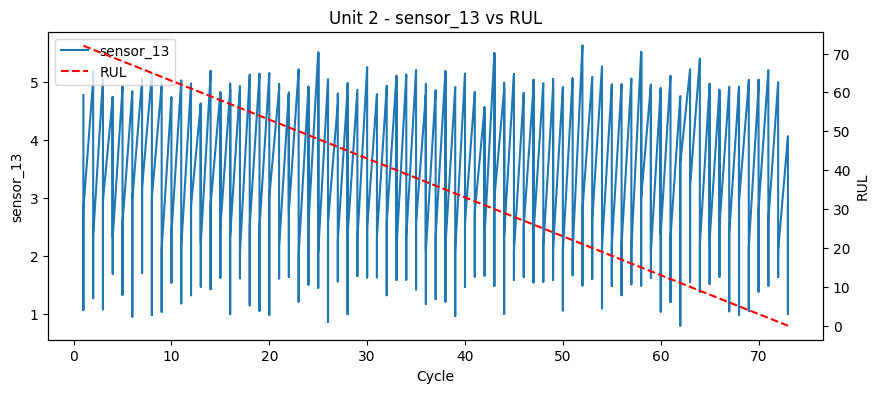

In [ ]:
df = DataFrame(X_s_dev, columns=[f"sensor_{i}" for i in range(X_s_dev.shape[1])])

# Add auxiliary info
df["unit"]  = A_dev[:, 0].astype(int)
df["cycle"] = A_dev[:, 1].astype(int)
df["Fc"]    = A_dev[:, 2].astype(int)
df["hs"]    = A_dev[:, 3].astype(int)

# Add target (RUL)
df["RUL"] = Y_dev

unit_to_plot = 2          # pick a unit
sensor = "sensor_13"       # pick a sensor column name

df_unit = df[df["unit"] == unit_to_plot]

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(df_unit["cycle"], df_unit[sensor], label=sensor)
ax1.set_xlabel("Cycle")
ax1.set_ylabel(sensor)

ax2 = ax1.twinx()
ax2.plot(df_unit["cycle"], df_unit["RUL"], linestyle="--", color="red", label="RUL")
ax2.set_ylabel("RUL")

# Merge legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title(f"Unit {unit_to_plot} - {sensor} vs RUL")
plt.show()


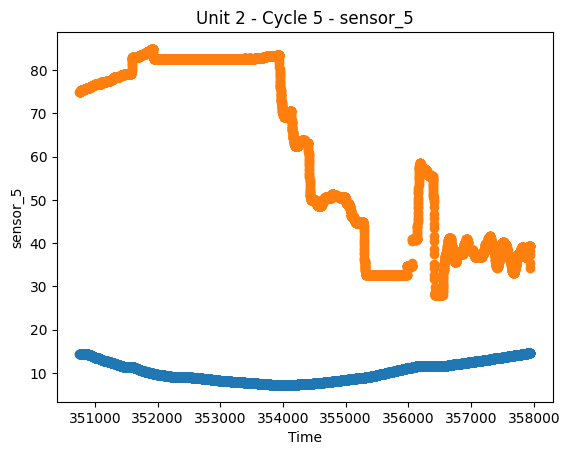

In [22]:
unit_to_plot = 2          # pick a unit
cycle_to_plot = 5      # pick a cycle 
sensor = "sensor_5"       # pick a sensor column name

df = DataFrame(X_s_dev, columns=[f"sensor_{i}" for i in range(X_s_dev.shape[1])])
df["unit"]  = A_dev[:, 0].astype(int)
df["cycle"] = A_dev[:, 1].astype(int)
df["tra"] = W_dev[:, 2].astype(float)

df_unit_cycle = df[(df["unit"] == unit_to_plot) & (df["cycle"] == cycle_to_plot)]
df_unit_cycle.describe()

plt.plot(df_unit_cycle[sensor], 'o')
plt.xlabel("Time")
plt.ylabel(sensor)
plt.title(f"Unit {unit_to_plot} - Cycle {cycle_to_plot} - {sensor}")
plt.plot(df_unit_cycle["tra"], 'o')

## Datenaufbereitung

In [4]:
# Train
fc = A_dev[:, 0].reshape(-1, 1)
X_dev = X_s_dev
X_train = np.concatenate((X_dev, fc, W_dev), axis=1)
Y_train = Y_dev.ravel()

# Test
fc_test = A_test[:, 0].reshape(-1, 1)
X_test = X_s_test
X_test = np.concatenate((X_test, fc_test, W_test), axis=1)
Y_test = Y_test.ravel()

## XGBoost

In [5]:
# Import
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

In [6]:
feature_names = (X_s_var + ["fc"] + W_var)
dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=Y_test, feature_names=feature_names)

### Model Training

In [ ]:
# Training parameters
params = {
    "objective": "reg:squarederror",   # regression
    "max_depth": 5,                    # tree depth
    "eta": 0.05,                       # learning rate
    "subsample": 0.8,                  # row sampling
    "colsample_bytree": 0.8,           # feature
    "gamma": 0.1,                      # require improvement to split 
    "tree_method": "hist",             # use GPU for training
    "device": "cuda",                  # use GPU
    "seed": 42
}

# Train model
num_round = 600
evallist = [(dtrain, "train"), (dtest, "eval")]

bst = xgb.train(
    params, 
    dtrain, 
    num_round, 
    evals=evallist, 
    #early_stopping_rounds=20,  # stop if no improvement
    verbose_eval=10            # print progress every 10 rounds
)

bst.save_model("xgb_rul_nonsplit.json")

[0]	train-rmse:21.33594	eval-rmse:21.12053
[10]	train-rmse:20.18091	eval-rmse:20.70474
[20]	train-rmse:19.53221	eval-rmse:20.69880
[30]	train-rmse:18.98591	eval-rmse:20.57145
[40]	train-rmse:18.30755	eval-rmse:19.96488
[50]	train-rmse:17.64430	eval-rmse:19.39772
[60]	train-rmse:17.18318	eval-rmse:19.03028
[70]	train-rmse:16.77200	eval-rmse:18.67700
[80]	train-rmse:16.33354	eval-rmse:18.29383
[90]	train-rmse:15.96691	eval-rmse:17.95767
[100]	train-rmse:15.56410	eval-rmse:17.61590
[110]	train-rmse:15.26451	eval-rmse:17.39389
[120]	train-rmse:14.96076	eval-rmse:17.40266
[130]	train-rmse:14.61394	eval-rmse:17.10750
[140]	train-rmse:14.35076	eval-rmse:17.11367
[150]	train-rmse:14.05407	eval-rmse:16.88162
[160]	train-rmse:13.80266	eval-rmse:16.68100
[170]	train-rmse:13.61471	eval-rmse:16.96948
[180]	train-rmse:13.35979	eval-rmse:16.76651
[190]	train-rmse:13.14868	eval-rmse:16.85341
[200]	train-rmse:12.95993	eval-rmse:16.70493
[210]	train-rmse:12.77294	eval-rmse:16.81036
[220]	train-rmse:12.6

### Vorhersage

In [7]:
# Load the model
model = xgb.Booster()
model.load_model("../models/xgb_rul_nonsplit.json")

# Predict
Y_pred = model.predict(dtest)

### Evaluation

In [8]:
# Evaluation
rmse = root_mean_squared_error(Y_test, Y_pred)
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 15.60


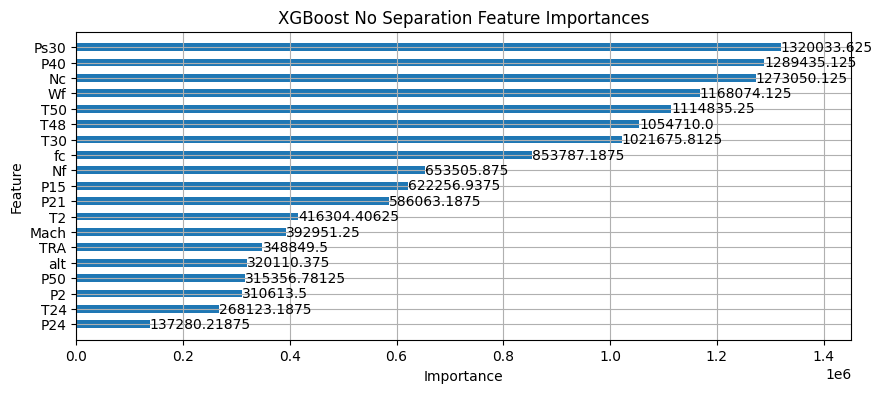

In [8]:
# Feature importances
fig, ax = plt.subplots(figsize=(10, 4))
xgb.plot_importance(model, importance_type="gain", height=0.5, ax=ax)
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")
ax.set_title("XGBoost No Separation Feature Importances")
plt.show()

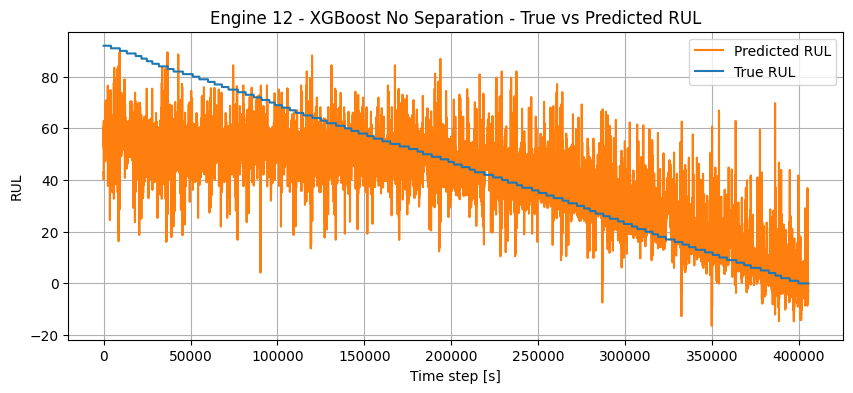

In [10]:
unit_ids_test = A_test[:, 0]
unit = 12
indices = np.where(unit_ids_test == unit)[0]

plt.figure(figsize=(10, 4))
plt.plot(Y_pred[indices], label="Predicted RUL", color='tab:orange')
plt.plot(Y_test[indices], label="True RUL", color='tab:blue')
plt.title(f"Engine {unit} - XGBoost No Separation - True vs Predicted RUL")
plt.xlabel("Time step [s]")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()